In [1]:
using Random, Plots
import Statistics
using LinearAlgebra

In [2]:
function spread_walk(walk)
    len = length(walk)
    arr = zeros(2*len-1)
    
    for ind in 1:len-1
        arr[2*ind-1] = walk[ind]
        arr[2*ind] =  (0.5 * (walk[ind] + walk[ind+1]) ) #issue here?
    end
    arr[2*len-1] = walk[len]
    
    return arr
end

function refine_walk(walk)
    len = length(walk)
    arr = zeros(2*len-1)
    
    for ind in 1:len-1
        arr[2*ind-1] = walk[ind]
        arr[2*ind] =  (0.5 * (walk[ind] + walk[ind+1]) .+ (((√Δt)/2)*randn(1))[1]) #issue here?
    end
    arr[2*len-1] = walk[len]
    
    return arr
end

refine_walk (generic function with 1 method)

In [3]:
const T = 1
const N = 1000
const Δt = T/N

0.001

In [4]:
#Create random walk and wiener process
η = (√Δt) * randn(N)
Wₜ = cumsum(η);

In [5]:
0.5 * (Wₜ[N]^2 + T)

3.5551921787909118

In [6]:
dot(η, Wₜ)

3.589059256451891

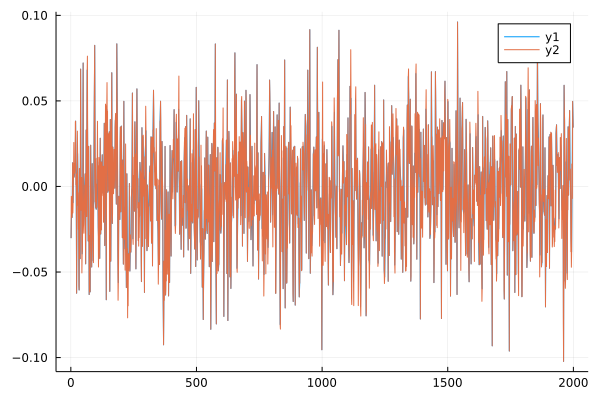

In [7]:
η2 = refine_walk(η); #error here?

plot([spread_walk(η),η2])

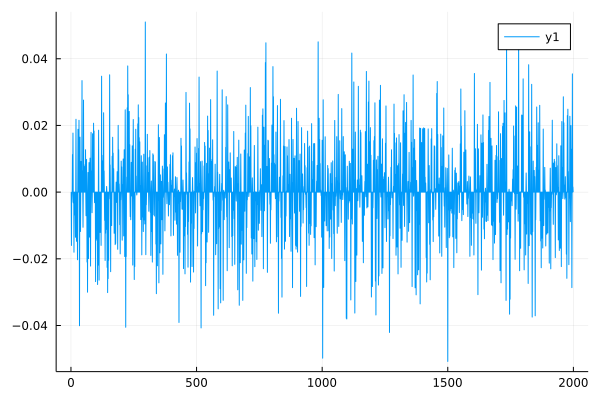

In [8]:
plot([spread_walk(η)-η2])

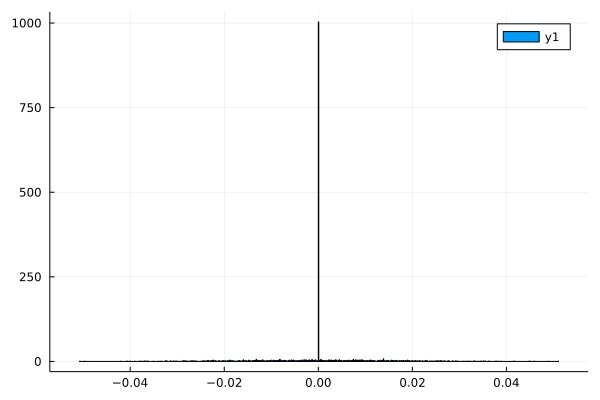

1999-element Vector{Float64}:
  0.0
 -0.015988574063348717
  0.0
 -0.0030589390742977157
  0.0
  0.011252372375337208
  0.0
  0.017706031461082083
  0.0
 -0.003273632984156627
  0.0
 -0.018018747695431568
  0.0
  ⋮
 -0.008853641655710634
  0.0
  0.019972184798550528
  0.0
  0.012861379367232355
  0.0
 -0.02863674479487559
  0.0
  0.03545240466207151
  0.0
  0.0015499272248937768
  0.0

In [9]:
Statistics.var(η2),Statistics.var(η)

(0.0009318858815024094, 0.001062686457421799)

In [10]:
dot(η2, cumsum(η2))

14.760184109830519

# Significantly needs work
for some reason it doesn't seem to converge